In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.shape

(50000, 2)

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
X = df['review']; y = df['sentiment']

Классы идеально сбалансированные:

In [6]:
y.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
le = LabelEncoder()

In [9]:
y_le = le.fit_transform(y)

Разбиваем данные на train/test, отложив 30% наблюдений для тестирования:

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.3, random_state = 42)

Применим tf-idf преобразование. Будем использовать как отдельные токены, так и биграммы, отсеим английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2, max_df=0.5, norm=None)

In [14]:
tf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=2, ngram_range=(1, 2), norm=None, preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [15]:
XTrainTfidf = tf_vectorizer.fit_transform(X_train)
XTestTfidf = tf_vectorizer.transform(X_test)

In [16]:
XTrainTfidf.shape, XTestTfidf.shape

((35000, 427136), (15000, 427136))

Построим логистическую регрессию с кросс-валидацией и настройкой параметра регуляризации Cs=[0.01,0.1,1,10,100].

In [17]:
from sklearn.linear_model import LogisticRegressionCV

In [18]:
logit_cv = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100], random_state=42, n_jobs=-1, verbose=3)

In [19]:
logit_cv

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100], class_weight=None, cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=42, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=3)

In [20]:
logCV = logit_cv.fit(XTrainTfidf, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


In [21]:
logCVpred = logit_cv.predict(XTestTfidf)

Посмотрим на значения метрик качества бинарной классификации:

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score

In [23]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}\n" +\
                 "Cohen Кappa: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    cohenkappa = cohen_kappa_score(prediction, actual)
       
    quality_list = [acc, precision, recall, f1, rocauc, cohenkappa]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            acc, precision, recall,
            f1, rocauc, cohenkappa))
        print("======================\n")
    
    return quality_list

In [24]:
LogCVQuality = quality_report(logCVpred, y_test)


=== Quality Report ===
Accuracy: 	 0.901
Precision: 	 0.910
Recall: 	 0.896
f1_score: 	 0.903
ROC-AUC: 	 0.901
Cohen Кappa: 	 0.802



Видим хорошее качество классификации по всем использованным метрикам.

Будем оценивать значимость слова для результата отзыва на фильм по величине 
соответствующего коэффициента регрессии.
Возьмем 25 наибольших коэффициентов для предсказания положительного отзыва (класс "1")  и 
25 наименьших коэффициентов для предсказания отрицательного отзыва (класс "0"). 

In [25]:
coefs = logCV.coef_[0]

In [26]:
feature_names = tf_vectorizer.get_feature_names()

In [27]:
Weights = pd.DataFrame({'feature': feature_names, 'weight': coefs})

In [28]:
Weights.set_index('feature', inplace=True)

In [29]:
pos = Weights.sort_values(["weight"], ascending=False)

In [30]:
neg = -Weights.sort_values(["weight"], ascending=True)

## Топ-25 типичных слов в положительных отзывах к фильмам:

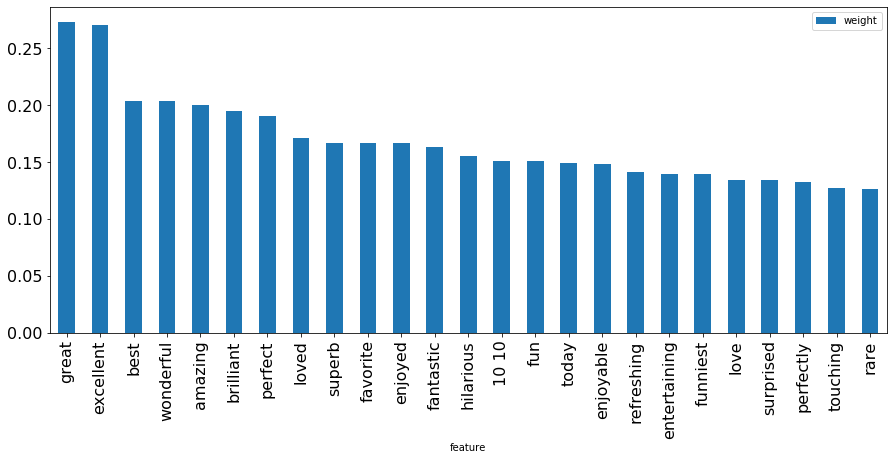

In [31]:
pos[:25].plot(kind ='bar', figsize = (15, 6), fontsize=16);

## Топ-25 типичных слов в отрицательных отзывах к фильмам: 

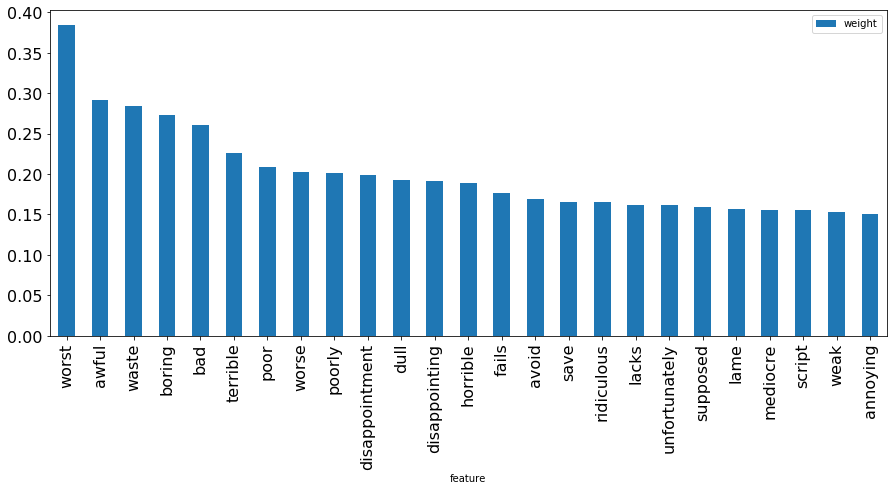

In [32]:
neg[:25].plot(kind ='bar', figsize = (15, 6), fontsize=16);